In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import h5py
import pickle
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision.models import resnet18
from torchvision import transforms
from tqdm import tqdm_notebook

module_path = os.path.abspath(os.path.join('~/tmp/pycharm_project_17'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [3]:
from tmp.pycharm_project_17.cpc.models.cpc import InfoNCE, fix_resnet, simpleCNN
from tmp.pycharm_project_17.cpc.models.resnet import resnet18 as custom_resnet18
from tmp.pycharm_project_17.cpc.utils import extractPatches, PictureDataset, EncodePatches, validation, training
from tmp.pycharm_project_17.tests.models import ReferenceInfoNCE

### Select Device

In [4]:
device = torch.device('cuda:1')

### Prepare Data

In [ ]:
f = h5py.File('/home/data/imagenet/imagenet64.hdf5', 'r',libver='latest')

### Parameters

In [ ]:
batch_size = 10
hidden_size = 128
enc_size = 256
N_predict = 35
N_negatives = 10
patch_size = (16, 16)

### Get Data

In [ ]:
try:# Find mappings of imagenet subset if exists
    with open('./top-100-lables-indices-train.pickle', "br") as file:
        index_map = np.array(pickle.load(file))
        
    with open("./label_map.pickle", "br") as file:
        label_map = pickle.load(file)

except FileNotFoundError:
    print("file not found")
    index_map = None
    label_map = None

patches = extractPatches(patch_size)
data = PictureDataset(f['train'], transform=patches, index_map=index_map, label_map=label_map)
dataloader = DataLoader(data, batch_size=batch_size)

### Prepare Models

In [ ]:
rnn = nn.GRU(enc_size, hidden_size, 1, batch_first=True).to(device)
#custom_resnet = fix_resnet(resnet18(pretrained=True)).to(device)
#custom_resnet = simpleCNN().to(device)
custom_resnet = custom_resnet18(num_classes=256).to(device)

In [ ]:
criterion = InfoNCE(N_predict, N_negatives, enc_size, hidden_size, same_image=True, device=device)
#criterion = ReferenceInfoNCE(N_predict, N_negatives, enc_size, hidden_size, device=device)
criterion.to(device)

InfoNCE(
  (logsoftmax): LogSoftmax()
)

In [ ]:
optimizer = optim.Adam(list(rnn.parameters()) + list(criterion.parameters()) + list(custom_resnet.parameters()))
custom_resnet.train()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
  (selu): SELU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): noBatchnorm()
      (selu): SELU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): noBatchnorm()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): noBatchnorm()
      (selu): SELU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): noBatchnorm()
    )
  )
  (layer2): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 128, kernel_

### Simple Classifier for Verification

In [ ]:
# Get patch dimensions
test_data = next(iter(dataloader))
n_patches_x = test_data["image"].shape[1]
n_patches_y = test_data["image"].shape[2]
print(test_data["image"].shape)

torch.Size([10, 7, 7, 3, 16, 16])


In [ ]:
classifier = nn.Linear(enc_size, 1000).to(device)
class_criterion = nn.modules.CrossEntropyLoss()
class_optimizer = optim.SGD(classifier.parameters(), lr=0.01)

# Avg Pooling for the linear classifier
avg_pooling = nn.AdaptiveAvgPool2d((1, 1))

### Train

In [ ]:
same_batch = False
loss_hist = []
class_loss_hist = []
total = len(dataloader)

tqdm_iter = tqdm_notebook(
    enumerate (dataloader, 1),
    desc="Learning..",
    total=total
)
for i, data in tqdm_iter:
    if i > total:
        break
        
    if same_batch:
        data = test_data
    image = data["image"].type(torch.FloatTensor).to(device)
    label = data["label"].to(device)
    
    # Merge batch- and image-dimension
    img_patches=image.view((-1,3)+patches.patch_size)
    
    enc_patches = custom_resnet(img_patches)

    # Concatenate all patches (x- and y-dimension)
    enc_patches = enc_patches.view((batch_size, n_patches_x * n_patches_y, -1))    

    # Apply rnn
    outputs, hidden = rnn(enc_patches)    
    optimizer.zero_grad()
    loss = criterion(enc_patches, outputs)
    loss_hist.append(loss.item())
    loss.backward()
    optimizer.step()
    
    # Mean Pooling the 7x7x256-d Data for the classifier to a singel 256-d vector
    enc_patches = enc_patches.view((batch_size, n_patches_x, n_patches_y, -1)).permute(0, 3, 1, 2)
    enc_patches = avg_pooling(enc_patches.detach()).reshape(batch_size, enc_size)
    
    # Teach Linear Layer for Validation
    out = classifier(enc_patches)
    class_optimizer.zero_grad()
    class_loss = class_criterion(out, label)
    class_loss_hist.append(class_loss.item())
    class_loss.backward()
    class_optimizer.step()
    
    desc = "Last loss  {:.5f}".format(loss)
    tqdm_iter.set_description_str(desc=desc)


In [ ]:
torch.save(
    {
        "meta": {
            "batcH_size": batch_size,
            "hidden_size": hidden_size,
            "enc_size": enc_size,
            "N_predict": N_predict,
            "N_negatives": N_negatives,
            "patch_size": patch_size
        },
        "resnet": custom_resnet.state_dict(),
        "rnn": rnn.state_dict(),
        "classifier": classifier.state_dict()
    }, "./trained_models/cpc.pth"
)

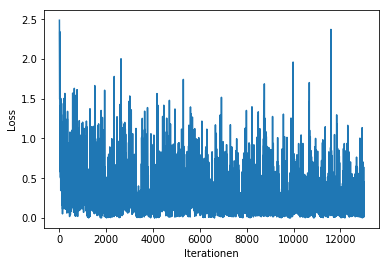

In [35]:
plt.plot(loss_hist)
plt.xlabel("Iterationen")
plt.ylabel("Loss")
plt.savefig("cpc_loss.png")
plt.show()

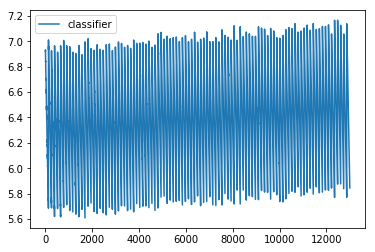

In [28]:
plt.plot(class_loss_hist, label="classifier")
plt.legend()
plt.show()

## Classifier with pretrained cpc-resnet

In [ ]:
classifier = nn.Linear(enc_size, 100).to(device)

In [ ]:
encoder = EncodePatches(custom_resnet, device=device)

In [ ]:
all_losses = training(
    net=classifier,
    num_epochs=1,
    data_loader=dataloader,
    print_every=100,
    # max_runs=100,
    device=device,
    criterion=nn.modules.CrossEntropyLoss().cuda(),
    transform=encoder,
    tqdm=tqdm_notebook
)

In [ ]:
torch.save(classifier.state_dict(), "./trained_models/cpc_classifier.pth")

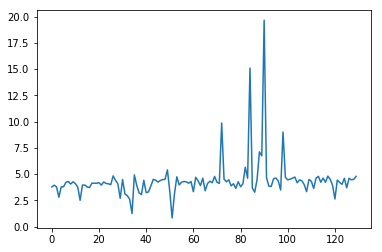

In [24]:
plt.plot(all_losses)
plt.show()

In [25]:
try:# Find mappings of imagenet subset if exists
    with open('./top-100-lables-indices-test.pickle', "br") as file:
        index_map = np.array(pickle.load(file))
        
    with open("./label_map.pickle", "br") as file:
        label_map = pickle.load(file)

except FileNotFoundError:
    print("file not found")
    index_map = None
    label_map = None
    
verify_data = PictureDataset(f['validation'], transform=patches, index_map=index_map, label_map=label_map)
verify_dataloader = DataLoader(verify_data, batch_size=100)

In [26]:
validation(classifier, verify_dataloader, device=device, transform=encoder, tqdm=tqdm_notebook)

Accuracy of the network: 1 %
96


In [29]:
96/len(verify_data)

0.0192